In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
import pylab as plt
from scipy import stats
import xlwings as xw

/Users/matthias/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel + 1):


In [89]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-02-22/"
#path = "/Users/matthias/Desktop/PhD Temp/2017-02-22/"
#path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 5955
files_end = 6164

In [133]:
# cup configuration
#cup_config = cycle_Sb
Sn_isotopes = ["112", "114", "115", "116", "117", "118", "119", "120", "122", "124"]
cup_config = cycles2

# Mass Range of cup configuration
mass_range = cycles2_mass_range

# Isotopes used for Interference correction
#corr_isotopes_1 = {"Cd" : "111", "Te" : "125"}
corr_isotopes_2 = {"Cd" : "111", "Te" : "125", "Xe" : "129"}
#corr_isotopes_2 = {}
corr_isotopes_Sb = {"Te": "125"}

norm_ratio = ["124","117"]
denom_isotope = norm_ratio[1]
Sn_monitor = ["111", "113", "125"]


def eval_iso_list(isotopes_list,norm_ratio, monitor_iso):
    isotope_nom = norm_ratio[0]
    isotope_den = norm_ratio[1]
    isotopes_list.remove(norm_ratio[1])
    for i in range(len(monitor_iso)):
        isotopes_list.append(monitor_iso[i])
    isotopes_list.sort()
    return isotopes_list

isotope_ls = eval_iso_list(Sn_isotopes, norm_ratio, Sn_monitor)

data_sample_column = [(i + "/" + denom_isotope) for i in isotope_ls]    
isotopes = [isotope_ls]

#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True
# background correction
blk_corr = True

In [88]:
database["Sn"]["Ratios"].get_all_ratios("116")

{'112': 0.04012733280838835,
 '114': 0.02718272796408838,
 '115': 0.013952768411772228,
 '116': 0.6003216970529051,
 '117': 0.3167343038085431,
 '119': 0.3545801449655757,
 '120': 1.346012773661222,
 '122': 0.19124957095842837,
 '124': 0.23903571644894908}

In [60]:
mass_range.get_mass_range()

{'110': ['Pd', 'Cd'],
 '111': ['Cd'],
 '112': ['Sn', 'Cd'],
 '113': ['Cd', 'In'],
 '114': ['Sn', 'Cd'],
 '115': ['Sn', 'In'],
 '116': ['Sn', 'Cd'],
 '117': ['Sn'],
 '118': ['Sn'],
 '119': ['Sn'],
 '120': ['Sn', 'Te'],
 '121': ['Sb'],
 '122': ['Sn', 'Te'],
 '123': ['Sb', 'Te'],
 '124': ['Sn', 'Te', 'Xe'],
 '125': ['Te'],
 '126': ['Te', 'Xe'],
 '127': ['I'],
 '129': ['Xe'],
 '131': ['Xe']}

In [61]:

mass_range.get_graph_of_corr(corr_isotopes_2)

{'110': {'111'},
 '111': set(),
 '112': {'111'},
 '113': set(),
 '114': {'111'},
 '115': set(),
 '116': {'111'},
 '117': set(),
 '118': set(),
 '119': set(),
 '120': {'125'},
 '121': set(),
 '122': {'125'},
 '123': {'125'},
 '124': {'125', '129'},
 '125': set(),
 '126': {'129'},
 '127': set(),
 '129': set(),
 '131': set()}

In [62]:
mass_range.get_order_of_corr(corr_isotopes_2)

[{'111', '113', '115', '117', '118', '119', '121', '125', '127', '129', '131'},
 {'110', '112', '114', '116', '120', '122', '123', '124', '126'}]

In [91]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
#files_1 = range(files_start, files_end, 1)
files_1 = range(6411,6518,1) + range(6526,6534, 1) + range(6537,6577, 1)

for sample in files_1:
    
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    #df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)

#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(5234)

In [132]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    data_sample = new_corr.internal_norm_1(norm_ratio, denom_isotope, iter_beta)
    #data_sample = new_corr.raw_ratios_corr(denom_isotope)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = new_corr.mad_outlier_rejection(data_sample)
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

KeyError: '116'

In [131]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
df_internal_sub["Te/Sn"] = (df_internal_norm["125"]/7.0509)/(df_internal_norm["118"]/24.223)

#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.952)/(df_internal_norm["118"]/24.223)
#df_internal_sub = df_internal_sub[df_internal_sub["118"] >= 7]
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")
df_internal_sub

KeyError: 'date'

In [116]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SD2])
df_internal_norm_mean["sample"] = df_internal_sub[~df_internal_sub.index.duplicated(keep='first')]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_sub[~df_internal_sub.index.duplicated(keep='first')]["sample"]
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
#df_internal_norm_mean = df_internal_norm_mean[df_internal_norm_mean["118"] >= 7]
df_internal_norm_mean
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,111/117,112/117,113/117,114/117,115/117,116/117,118/117,119/117,120/117,122/117,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2017-02-23 11:27:00,1.353531e-04,0.126678,1.980205e-04,0.085766,0.043974,1.894969,3.156936,1.119906,4.249255,0.603914,...,0.127794,0.408843,0.146967,0.564982,0.082400,0.105629,-6.563593e-06,7.415286e-05,-5.609538e-05,NIST 5.5ppb
2017-02-23 11:52:00,6.939182e-05,0.126613,-5.555444e-05,0.085691,0.043932,1.894848,3.156800,1.119843,4.249271,0.603799,...,0.127400,0.407570,0.146510,0.563268,0.082141,0.105321,4.609147e-06,3.802201e-05,3.949931e-05,NIST 5.5ppb
2017-02-23 12:07:00,1.038128e-04,0.126550,1.386011e-04,0.085749,0.043832,1.894635,3.156622,1.119788,4.248852,0.603880,...,0.127465,0.407772,0.146590,0.563574,0.082211,0.105405,3.716082e-07,5.688629e-05,3.835018e-06,NIST 5.5ppb
2017-02-23 12:19:00,1.036505e-04,0.126765,1.042246e-04,0.085824,0.044014,1.894955,3.156955,1.119942,4.249646,0.604050,...,0.128071,0.409755,0.147308,0.566353,0.082626,0.105909,2.957376e-06,5.680353e-05,2.503541e-05,NIST 5.5ppb
2017-02-23 12:45:00,1.154956e-04,0.126687,1.162672e-04,0.085939,0.043949,1.894815,3.156794,1.119820,4.249060,0.603833,...,0.127198,0.406936,0.146284,0.562400,0.082029,0.105178,5.391992e-06,6.327661e-05,4.690377e-05,NIST 5.5ppb
2017-02-23 12:59:00,-2.530303e-05,0.126790,1.043684e-04,0.086056,0.043998,1.894769,3.156602,1.119753,4.248545,0.603810,...,0.126209,0.403739,0.145133,0.557930,0.081377,0.104341,-5.328980e-06,-1.386416e-05,-4.520430e-05,NIST 5.5ppb
2017-02-23 13:12:00,1.282984e-04,0.126612,8.900716e-05,0.085852,0.043938,1.894679,3.156394,1.119712,4.248802,0.603738,...,0.126606,0.405004,0.145598,0.559801,0.081641,0.104701,-1.056792e-05,7.028859e-05,-8.958426e-05,NIST 5.5ppb
2017-02-23 13:37:00,7.654846e-05,0.126842,2.136004e-04,0.086017,0.044046,1.894890,3.156610,1.119867,4.249174,0.603807,...,0.125339,0.400988,0.144169,0.554284,0.080849,0.103680,1.950403e-06,4.190589e-05,1.808575e-05,NIST 5.5ppb
2017-02-23 13:51:00,-1.177961e-04,0.126854,8.509650e-05,0.086040,0.044043,1.894652,3.156549,1.119799,4.249307,0.603885,...,0.126472,0.404618,0.145472,0.559368,0.081604,0.104643,1.092279e-05,-6.450416e-05,9.324223e-05,NIST 5.5ppb + 0.3ppb Mo


In [108]:
df_internal_norm_sample_sd = df_internal_norm_mean.groupby(df_internal_norm_mean["sample"]).agg([np.mean, SD2])
df_internal_norm_sample_sd

111/117             112/117             113/117  \
                              mean       SD2      mean       SD2      mean   
sample                                                                       
J.W. Leach 1b             0.000976  0.000000  0.126788  0.000000  0.001035   
J.W. Leach 2a             0.000223  0.000000  0.126625  0.000000  0.000207   
J.W. Leach 5b             0.000296  0.000000  0.126689  0.000000  0.000306   
NIST 40ppb                0.000011  0.000032  0.126720  0.000049  0.000020   
NIST 40ppb + 0.002ppb U   0.000012  0.000012  0.126731  0.000033  0.000038   
NIST 40ppb + 0.1ppb Zr    0.000021  0.000002  0.126702  0.000003  0.000033   
NIST 40ppb + 0.2ppb Ru    0.000020  0.000011  0.126703  0.000021  0.000023   
NIST 40ppb + 0.5ppb Pd    0.000007  0.000000  0.126700  0.000000  0.000016   
NIST 40ppb + 2.5ppb Mo    0.000013  0.000009  0.126718  0.000021  0.000022   
NIST 5.5ppb               0.000043  0.000164  0.126726  0.000303  0.000073   
NIST 5.5ppb + 0.024 Te    0.000116  0.000000  0.126582  0.000000  0.000014   
NIST 5.5ppb + 0.1ppb Ru   0.000010  0.000001  0.126752  0.000001  0.000127   
NIST 5.5ppb + 0.3ppb Mo  -0.000118  0.000000  0.126854  0.000000  0.000085   
NIST 5.5ppb + Te         -0.000085  0.000000  0.126822  0.000000 -0.000061   
NIST 9ppb                 0.000030  0.000135  0.126718  0.000236  0.000041   
NIST 9ppb + 0.05ppb Te    0.000184  0.000000  0.126607  0.000000  0.000035   
NIST 9ppb +0.1ppb Ru      0.000087  0.000000  0.126599  0.000000  0.000144   
NIST 9ppb +0.3ppb Mo      0.000037  0.000029  0.126780  0.000095  0.000043   
ZH09-05 23.3_3b_3 35ppb   0.000147  0.000000  0.126734  0.000000  0.000162   
ZH09-05 23.3_3b_3 5.5ppb -0.000038  0.000000  0.126894  0.000000  0.000229   
ZH09-05 23.3_3b_3 9ppb    0.000181  0.000000  0.126687  0.000000  0.000268   

                                         114/117             115/117  \
                                   SD2      mean       SD2      mean   
sample                                                                 
J.W. Leach 1b             0.000000e+00  0.085801  0.000000  0.044070   
J.W. Leach 2a             0.000000e+00  0.085772  0.000000  0.044096   
J.W. Leach 5b             0.000000e+00  0.085781  0.000000  0.044011   
NIST 40ppb                2.542356e-05  0.085806  0.000053  0.044021   
NIST 40ppb + 0.002ppb U   2.448197e-05  0.085815  0.000006  0.044022   
NIST 40ppb + 0.1ppb Zr    2.965462e-07  0.085783  0.000020  0.044026   
NIST 40ppb + 0.2ppb Ru    1.488612e-05  0.085782  0.000034  0.044036   
NIST 40ppb + 0.5ppb Pd    0.000000e+00  0.085784  0.000000  0.044030   
NIST 40ppb + 2.5ppb Mo    8.084156e-06  0.085809  0.000003  0.044014   
NIST 5.5ppb               2.006922e-04  0.085817  0.000360  0.044003   
NIST 5.5ppb + 0.024 Te    0.000000e+00  0.085369  0.000000  0.044035   
NIST 5.5ppb + 0.1ppb Ru   3.911973e-05  0.085843  0.000327  0.044022   
NIST 5.5ppb + 0.3ppb Mo   0.000000e+00  0.086040  0.000000  0.044043   
NIST 5.5ppb + Te          0.000000e+00  0.085886  0.000000  0.043918   
NIST 9ppb                 1.195916e-04  0.085792  0.000237  0.044026   
NIST 9ppb + 0.05ppb Te    0.000000e+00  0.085629  0.000000  0.044033   
NIST 9ppb +0.1ppb Ru      0.000000e+00  0.085720  0.000000  0.044026   
NIST 9ppb +0.3ppb Mo      3.046614e-05  0.085917  0.000062  0.044061   
ZH09-05 23.3_3b_3 35ppb   0.000000e+00  0.085817  0.000000  0.044029   
ZH09-05 23.3_3b_3 5.5ppb  0.000000e+00  0.086135  0.000000  0.044075   
ZH09-05 23.3_3b_3 9ppb    0.000000e+00  0.085787  0.000000  0.043994   

                                      ...          122                 124  \
                               SD2    ...         mean       SD2      mean   
sample                                ...                                    
J.W. Leach 1b             0.000000    ...     0.085838  0.000000  0.110175   
J.W. Leach 2a             0.000000    ...     0.128592  0.000000  0.164960   
J.W. Leach 5b             0.000000 

In [109]:
#df_internal_norm_mean.describe()

In [110]:
# variation of standard data + mean + 2SD
sel_ratio = "124/118"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 40ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].mean(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].mean()+ 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

KeyError: '124/118'

In [ ]:
# variation of standard data + meadian + 25% quantile + 75% quantile
sel_ratio = "120/118"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].median(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].quantile(0.25), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].quantile(0.75), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

In [ ]:
# outlier corr variation of standard data + meadian + 25% quantile + 75% quantile
sel_ratio = "120/118"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = new_corr.mad_outlier_rejection(plot_Nist.drop("sample", axis=1))
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].mean(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].mean()+ 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

In [125]:
std_used = "NIST 9ppb"
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == std_used)].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_internal_norm_mean[df_internal_norm_mean["118"] >= 0.1]
corr_values_2 = corr_values[corr_values["sample"] == std_used]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]
std_mean = corr_values[(corr_values["sample"] == std_used)].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*10000
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != std_used]
epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
#epsilon_comp.index = epsilon_comp["Date"]
#epsilon_comp.columns
epsilon_comp = epsilon_comp.sort_index(axis=0)

In [126]:
#epsilon_comp = epsilon_comp.drop([datetime.strptime("2017-02-24 15:18", "%Y-%m-%d %H:%M")])
epsilon_comp

,111/117,112/117,113/117,114/117,115/117,116/117,118/117,119/117,120/117,122/117,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2017-02-23 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 9ppb
2017-02-23 20:37:00,-6.895061e+04,0.045574,-39000.866953,-4.188761,1.300056,-0.049818,0.503656,0.430577,0.207746,0.565972,...,-31.281895,-30.443770,-30.370895,-30.352866,-29.113671,-29.298758,-2.351102e+04,-6.892762e+04,-2.346392e+04,NIST 9ppb
2017-02-23 20:52:00,2.247202e+04,-20.071124,-15415.124287,-14.846833,22.701650,0.153173,0.421280,-0.424946,0.309407,1.205923,...,-3950.004946,-3949.602922,-3950.075902,-3949.629679,-3948.774916,-3949.307619,-1.039341e+04,2.246092e+04,-1.064074e+04,NIST 5.5ppb
2017-02-23 21:05:00,-7.200977e+03,1.744215,-9560.034746,4.175350,-13.664415,0.480110,0.167933,-0.073443,0.409818,-0.423323,...,26.715085,26.575109,26.398400,26.749051,25.300867,25.293273,-1.905851e+04,-7.199567e+03,-1.908037e+04,NIST 9ppb
2017-02-23 21:30:00,-3.595213e+04,-7.433210,-9147.656530,-13.090047,12.158406,-0.597472,-0.451599,-0.590162,-0.585653,0.447749,...,-25.620133,-26.018718,-26.290996,-26.312749,-24.950895,-25.235766,-3.035396e+04,-3.596722e+04,-3.029594e+04,NIST 9ppb
2017-02-23 21:45:00,-2.444764e+04,2.845432,33145.607538,10.865564,-4.016041,0.368913,0.182711,0.546417,0.126171,-0.794166,...,1.858580,2.111515,2.544953,2.184463,1.096066,1.846560,-1.454127e+04,-2.444290e+04,-1.451708e+04,NIST 9ppb
2017-02-23 21:57:00,-7.010544e+03,0.910755,-28794.062339,-13.422382,8.288204,-0.291429,0.249642,-0.609512,0.118084,1.026480,...,21.869584,22.524908,21.936869,23.006941,24.676146,24.323660,1.510946e+04,-7.012611e+03,1.531961e+04,NIST 9ppb
2017-02-23 22:24:00,2.175482e+04,4.737765,19092.769852,11.541780,-1.488239,0.037842,-0.218407,0.464208,-0.264108,-0.333904,...,4.150198,3.333646,3.677343,2.485380,1.452132,0.902710,-4.549015e+02,2.176147e+04,-4.329774e+02,NIST 9ppb
2017-02-23 22:38:00,-5.335579e+03,9.062658,-7281.701793,21.135079,8.910319,0.912441,-0.126988,-0.604022,0.219138,0.971537,...,-126.773991,-126.948746,-127.614004,-126.906367,-126.455847,-127.685628,-1.781057e+03,-5.335688e+03,-1.710768e+03,NIST 9ppb +0.3ppb Mo


In [127]:
def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

epsilon = epsilon_comp.drop(["111", "125", "112", "114", "115", "116", "117", "118", "119", "120", "122", "124", "Cd/Sn", "Te/Sn"], axis = 1)
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2]), decimals=2)
epsilon_sum

111/117             112/117          113/117  \
                              mean         SD2    mean    SD2      mean   
sample                                                                    
J.W. Leach 2a             17596.75         NaN   -7.33    NaN  24214.04   
NIST 40ppb                -6354.88         NaN   -4.05    NaN  -5377.72   
NIST 5.5ppb               22472.02         NaN  -20.07    NaN -15415.12   
NIST 9ppb                  -387.68    79859.56   -0.05  13.53   2717.75   
NIST 9ppb + 0.05ppb Te    13838.54         NaN   -8.76    NaN -86584.41   
NIST 9ppb +0.1ppb Ru        542.99         NaN   -9.23    NaN   3967.33   
NIST 9ppb +0.3ppb Mo    1331818.36  3782042.47    6.12   8.32   9527.76   
ZH09-05 23.3_3b_3 9ppb   219491.98         NaN   -2.11    NaN  68758.48   

                                 114/117        115/117           ...     \
                             SD2    mean    SD2    mean    SD2    ...      
sample                                                            ...      
J.W. Leach 2a                NaN   -4.18    NaN   19.97    NaN    ...      
NIST 40ppb                   NaN    4.92    NaN    1.89    NaN    ...      
NIST 5.5ppb                  NaN  -14.85    NaN   22.70    NaN    ...      
NIST 9ppb               43300.36   -0.19  24.22   -0.41  19.10    ...      
NIST 9ppb + 0.05ppb Te       NaN  -12.22    NaN    7.00    NaN    ...      
NIST 9ppb +0.1ppb Ru         NaN  -15.89    NaN    9.06    NaN    ...      
NIST 9ppb +0.3ppb Mo    47544.33   16.05  14.37    0.84  22.84    ...      
ZH09-05 23.3_3b_3 9ppb       NaN  -10.08    NaN   -8.56    NaN    ...      

                       120/117       122/117       124/117          125/117  \
                          mean   SD2    mean   SD2    mean  SD2        mean   
sample                                                                        
J.W. Leach 2a             0.06   NaN    0.34   NaN     0.0  NaN   192356.10   
NIST 40ppb               -0.04   NaN   -0.22   NaN     0.0  NaN    -7390.28   
NIST 5.5ppb               0.31   NaN    1.21   NaN     0.0  NaN   -10653.27   
NIST 9ppb                 0.01  1.17    0.00  1.61     0.0  0.0     3958.00   
NIST 9ppb + 0.05ppb Te    0.11   NaN   -0.15   NaN     0.0  NaN  1199034.71   
NIST 9ppb +0.1ppb Ru     -0.05   NaN   -0.11   NaN     0.0  NaN   412574.93   
NIST 9ppb +0.3ppb Mo     -0.08  0.85    0.19  2.21     0.0  0.0     3837.25   
ZH09-05 23.3_3b_3 9ppb   -0.31   NaN   -0.82   NaN     0.0  NaN  -106114.36   

                                         113            
                              SD2       mean       SD2  
sample                                                  
J.W. Leach 2a                 NaN   22373.08       NaN  
NIST 40ppb                    NaN   12940.81       NaN  
NIST 5.5ppb                   NaN  -13263.13       NaN  
NIST 9ppb               218876.51    2657.22  43663.50  
NIST 9ppb + 0.05ppb Te        NaN -100337.22       NaN  
NIST 9ppb +0.1ppb Ru          NaN    3795.81       NaN  
NIST 9ppb +0.3ppb Mo     15692.43    9858.83  48463.11  
ZH09-05 23.3_3b_3 9ppb        NaN   76582.33       NaN  

[8 rows x 26 columns]

In [128]:
### sel_ratio = "112/118"
std = "NIST 100ppb"

def plot_epsilon(sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title("samples" + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

In [47]:
wb = xw.books.add()
#wb.sheets.add()
wb.sheets["Sheet1"].range('A1').value = df_all
df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).mean()
df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
wb.sheets["Sheet1"].range('A344').value = df_all_mean

AttributeError: 'module' object has no attribute 'books'

In [69]:
#wb.sheets.add()
wb.sheets[3].range('AF1').value = df_internal_sub
#df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).mean()
#df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
#xw.Range('A344').value = df_all_mean

In [70]:
#wb.sheets.add()
wb.sheets[4].range('A21').value = df_internal_norm_mean_sd

In [71]:
wb.sheets[4].range('BF21').value = epsilon_comp

In [72]:
#epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"]["117/118"].std()
wb.sheets[4].range('BF36').value = epsilon_sum

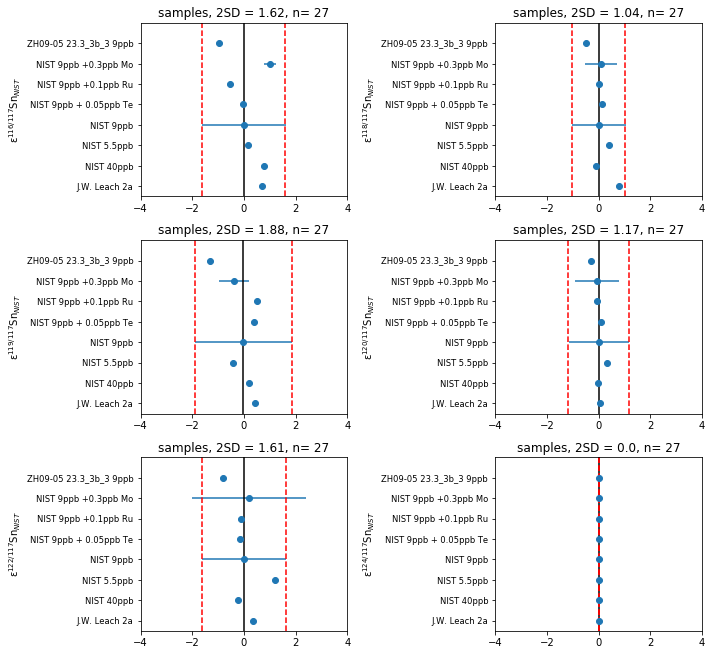

In [129]:
#sel_ratio = ["116/118", "117/118", "119/118", "120/118", "122/118", "124/118"]
sel_ratio = ["116/117", "118/117", "119/117", "120/117", "122/117", "124/117"]
#sel_ratio = ["116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]
#sel_ratio = ["112/120", "114/120", "115/120"]
#sel_ratio = ["112/118", "114/118", "115/118"]
xlim = [-4, 4]

fig = plt.figure(figsize=(10,15))

for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST 9ppb", xlim)
fig.tight_layout()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#savefig(path+"epsilon_x_bgd_122_118_2_200ppb_no_inter_corr.pdf", bbox_inches='tight')

In [ ]:
sel_ratio = "116/118"
epsilon_comp = epsilon_comp[epsilon_comp["sample"] == "NIST 200ppb"]
x = epsilon_comp.index
plt.plot(x, epsilon_comp[sel_ratio], marker="o")
plt.ylim([-0.5, 0.5])
#plt.xticks(x, epsilon_comp["sample"], size='small', rotation=90)
plt.axhline(epsilon_comp[sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[sel_ratio].mean()+ 2*epsilon_comp[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[sel_ratio].mean()- 2*epsilon_comp[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{118}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [69]:
df_all.to_csv(path + "Sn_H8_L4_2_cycles_NU_Signals_zero_corr.csv", mode='w', header=True)

In [117]:
df_internal_norm.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_124_117_bgd_corr_outlier_corr_Xe_new_all.csv", mode='w', header=True)

In [118]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_124_117_bgd_corr_outlier_corr_Xe_new.csv", mode='w', header=True)

In [37]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

NameError: name 'df_std' is not defined

In [ ]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [ ]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [ ]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [ ]:
#old Cd/Sn & Te/Sn extraction - doesn't include bgd corr
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "SQ") & (df_all["sample"] != "teflon blank")]
df_internal_sub["111"] = df_all_sub["L3 (1)"]
df_internal_sub["125"] = df_all_sub["H5 (2)"]
df_internal_sub["Cd/Sn"] = (df_all_sub["L3 (1)"]/12.722)/(df_all_sub["H4 (1)"]/24.223)
df_internal_sub["Te/Sn"] = (df_all_sub["H5 (2)"]/7.0509)/(df_all_sub["H4 (1)"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [ ]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date")

In [ ]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

In [ ]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

In [ ]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [ ]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

In [ ]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee